<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/Baryonator/blob/main/notebooks/LensingProbForwardModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this is a copy of LensingProbForwardModel.ipynb to figure out what is happening

In [2]:
# # Installing package
# !pip install --quiet --user git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git git+https://github.com/LSSTDESC/bayesian-pipelines-cosmology.git@u/EiffL/infrastructure
# # Downloading useful data
# !wget --quiet https://github.com/LSSTDESC/star-challenge/raw/main/cosmodc2-srd-sample/generation/shear_photoz_stack.hdf5
# !wget --quiet https://github.com/LSSTDESC/bayesian-pipelines-cosmology/raw/main/notebooks/forward_model/camels_25_64_pkloss.params

In [3]:
# !pip install diffrax

In [4]:
# !pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [5]:
# !pip install --upgrade jaxlib

In [1]:
%pylab inline
import h5py
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax_cosmo.scipy.integrate import simps
import astropy.units as u

from bpcosmo.pm import get_density_planes
from jaxpm.lensing import convergence_Born

import numpyro
import numpyro.distributions as dist

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Loading DC2 parameters

For now, just n(z), but we could also load masks and such

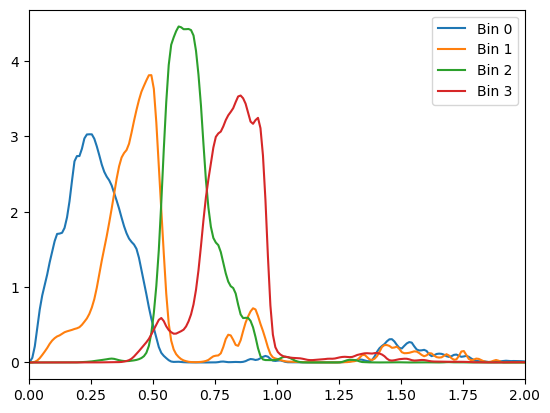

In [2]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,
                                   source[f"bin_{i}"][:],
                                   bw=0.01, zmax=2.5) for i in range(4)]
for i in range(4):
  plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2);

In [3]:
# Loads some correction factors to improve the resolution of the simulation
import pickle
params = pickle.load( open( "camels_25_64_pkloss.params", "rb" ) )

### Definition of the forward model

In [4]:
#@title Run Me


# This module contains utility functions to run a forward simulation
import jax
import jax.numpy as jnp

import jax_cosmo as jc

import numpyro
import numpyro.distributions as dist

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk
from jaxpm.lensing import density_plane
import haiku as hk

from jaxpm.painting import cic_paint, cic_read
from jaxpm.kernels import gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

__all__ = [
    'get_density_planes',
]

model = hk.without_apply_rng(
    hk.transform(lambda x, a: NeuralSplineFourierFilter(n_knots=16,
                                                        latent_size=32)(x, a)))


def linear_field(mesh_shape, box_size, pk):
  """
    Generate initial conditions.
    """
  kvec = fftk(mesh_shape)
  kmesh = sum(
      (kk / box_size[i] * mesh_shape[i])**2 for i, kk in enumerate(kvec))**0.5
  pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
      box_size[0] * box_size[1] * box_size[2])

  field = numpyro.sample(
      'initial_conditions',
      dist.Normal(jnp.zeros(mesh_shape), jnp.ones(mesh_shape)))

  field = jnp.fft.rfftn(field) * pkmesh**0.5
  field = jnp.fft.irfftn(field)
  return field


def get_density_planes(
    cosmology,
    density_plane_width=100.,  # In Mpc/h
    density_plane_npix=256,  # Number of pixels
    density_plane_smoothing=3.,  # In Mpc/h
    box_size=[400., 400., 4000.],  # In Mpc/h
    nc=[32, 32, 320],
    neural_spline_params=None):
  """Function that returns tomographic density planes
  for a given cosmology from a lightcone.

  Args:
    cosmology: jax-cosmo object
    density_plane_width: width of the output density slices
    density_plane_npix: size of the output density slices
    density_plane_smoothing: Gaussian scale of plane smoothing
    box_size: [sx,sy,sz] size in Mpc/h of the simulation volume
    nc: number of particles/voxels in the PM scheme
    neural_spline_params: optional parameters for neural correction of PM scheme
  Returns:
    list of [r, a, plane], slices through the lightcone along with their
        comoving distance (r) and scale factors (a). Each slice "plane" is a
        2d array of size density_plane_npix^2
  """
  # Initial scale factor for the simulation
  a_init = 0.01

  # Planning out the scale factor stepping to extract desired lensplanes
  n_lens = int(box_size[-1] // density_plane_width)
  r = jnp.linspace(0., box_size[-1], n_lens + 1)
  r_center = 0.5 * (r[1:] + r[:-1])
  a_center = jc.background.a_of_chi(cosmology, r_center)

  # Create a small function to generate the matter power spectrum
  k = jnp.logspace(-4, 1, 256)
  pk = jc.power.linear_matter_power(cosmology, k)
  pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk
                                                ).reshape(x.shape)

  # Create initial conditions
  initial_conditions = linear_field(nc, box_size, pk_fn)

  # Create particles
  particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),
                        axis=-1).reshape([-1, 3])

  # Initial displacement
  cosmology._workspace = {}  # FIX ME: this a temporary fix
  dx, p, f = lpt(cosmology, initial_conditions, particles, a=a_init)

#   @jax.jit
  def neural_nbody_ode(a, state, args):
    """
      state is a tuple (position, velocities ) in internal units: [grid units, v=\frac{a^2}{H_0}\dot{x}]
      See this link for conversion rules: https://github.com/fastpm/fastpm#units
      """
    cosmo, params = args
    pos = state[0]
    vel = state[1]

    kvec = fftk(nc)

    delta = cic_paint(jnp.zeros(nc), pos)

    delta_k = jnp.fft.rfftn(delta)

    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)

    # Apply a correction filter
    if params is not None:
      kk = jnp.sqrt(sum((ki / jnp.pi)**2 for ki in kvec))
      pot_k = pot_k * (1. + model.apply(params, kk, jnp.atleast_1d(a)))

    # Computes gravitational forces
    forces = jnp.stack([
        cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i) * pot_k), pos)
        for i in range(3)
    ],
                       axis=-1)

    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

    return jnp.stack([dpos, dvel], axis=0)

  # Evolve the simulation forward
  term = ODETerm(neural_nbody_ode)
  solver = Dopri5()
  saveat = SaveAt(ts=jnp.concatenate([jnp.atleast_1d(a_init), a_center[::-1]]))
  stepsize_controller = PIDController(rtol=1e-4, atol=1e-4)

  solution = diffeqsolve(term, solver, t0=a_init, t1=1., dt0=0.01,
                       y0=jnp.stack([particles+dx, p], axis=0),
                       args=(cosmology, neural_spline_params),
                       saveat=saveat,
                       adjoint=diffrax.RecursiveCheckpointAdjoint()
                       )
                      #  adjoint=diffrax.BacksolveAdjoint(solver=Dopri5()),
                      #  stepsize_controller=stepsize_controller)

  # res = odeint(neural_nbody_ode, [particles + dx, p],
  #              jnp.concatenate([jnp.atleast_1d(a_init), a_center[::-1]]),
  #              cosmology,
  #              neural_spline_params,
  #              rtol=1e-5,
  #              atol=1e-5)
  res = solution.ys[:,0]

  # Extract the lensplanes
  density_planes = []
  for i in range(n_lens):
    dx = box_size[0] / density_plane_npix
    dz = density_plane_width
    plane = density_plane(res[::-1][i],
                          nc, (i + 0.5) * density_plane_width / box_size[-1] *
                          nc[-1],
                          width=density_plane_width / box_size[-1] * nc[-1],
                          plane_resolution=density_plane_npix,
                          smoothing_sigma=density_plane_smoothing / dx)
    density_planes.append({
        'r': r_center[i],
        'a': a_center[i],
        'plane': plane,
        'dx': dx,
        'dz': dz
    })

  return density_planes

In [5]:
def forward_model(box_size=[200., 200., 2000.], # In Mpc/h
                  nc = [16, 16, 32],         # Number of pixels
                  field_size = 10,            # Size of the lensing field in degrees
                  field_npix = 16,           # Number of pixels in the lensing field
                  sigma_e = 0.25,             # Standard deviation of galaxy ellipticities
                  galaxy_density = 10.,       # Galaxy density per arcmin^2, per redshift bin
                  ):
    """
    This function defines the top-level forward model for our observations
    """
    # Sampling cosmological parameters and defines cosmology
    Omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.831, 0.14))
    Omega_b = 0.04
    h = 0.7
    n_s = 0.96
    w0 = -1
    cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma_8, Omega_b=Omega_b,
                       h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)

    # Generate lightcone density planes through an nbody
    density_planes = get_density_planes(cosmo, box_size=box_size, nc=nc,
                                      neural_spline_params=params,
                                      density_plane_npix=32,
                                      density_plane_smoothing=1.,
                                      density_plane_width=100.
                                      )
    # Create photoz systematics parameters, and create derived nz
    nzs_s_sys = [jc.redshift.systematic_shift(nzi,
                                            numpyro.sample('dz%d'%i, dist.Normal(0., 0.01)),
                                            zmax=2.5)
                for i, nzi in enumerate(nz_shear)]


    # Defining the coordinate grid for lensing map
    xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                             np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates
    coords = jnp.array((np.stack([xgrid, ygrid], axis=0)*u.deg).to(u.rad))

    # Generate convergence maps by integrating over nz and source planes
    convergence_maps = [simps(lambda z: nz(z).reshape([-1,1,1]) *
                              convergence_Born(cosmo, density_planes, coords, z), 0.01, 1.0, N=32)
                      for nz in nzs_s_sys]
    # Apply noise to the maps (this defines the likelihood)
    observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, sigma_e/jnp.sqrt(galaxy_density*(field_size*60/field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

    return observed_maps

Once the model is defined, it needs to be seeded, and then can be ran and traced if one wants to access all the stochastic variables.

In [6]:
# condition the model on a given set of parameters
fiducial_model = numpyro.handlers.condition(forward_model, {'omega_c': 0.3,
                                                            'sigma_8': 0.8})

# sample a mass map and save corresponding true parameters
model_trace = numpyro.handlers.trace(numpyro.handlers.seed(fiducial_model, jax.random.PRNGKey(42))).get_trace()

/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/var/folders/mc/gj6kz6750g7dks2k81t8xyl80000gn/T/ipykernel_33035/1556295860.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = sum(
/var/folders/mc/gj6kz6750g7dks2k81t8xyl80000gn/T/ipykernel_33035/1556295860.py:125: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum bu

In [ ]:
# plotting the trace
figure(figsize=[16,4])
for i in range(4):
    subplot(1,4,i+1)
    title('redshift bin %d'%i)
    imshow(model_trace['kappa_%d'%i]['value'],vmax=0.1,vmin=-0.1)
    axis('off')

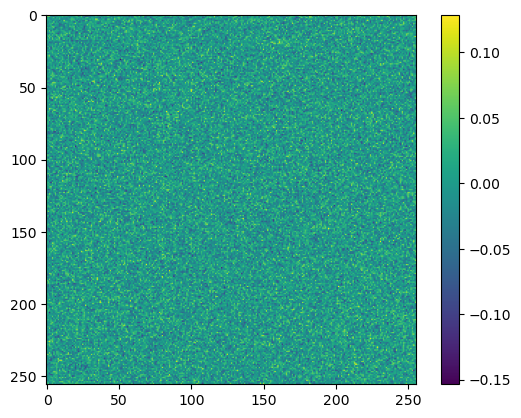

In [13]:
imshow(model_trace['kappa_0']['value'])
colorbar()

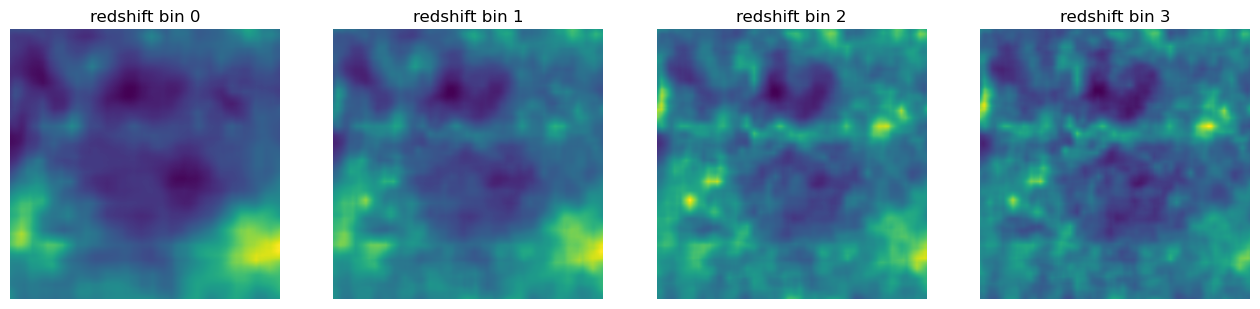

In [14]:
# plotting the trace
figure(figsize=[16,4])
for i in range(4):
    subplot(1,4,i+1)
    title('redshift bin %d'%i)
    imshow(model_trace['kappa_%d'%i]['fn'].mean)
    axis('off')

In [7]:
# @jax.jit
def timed_func(om, s8):

    # condition the model on a given set of parameters
    fiducial_model = numpyro.handlers.condition(forward_model, {'omega_c': om,
                                                              'sigma_8': s8})

    # sample a mass map and save corresponding true parameters
    model_trace = numpyro.handlers.trace(numpyro.handlers.seed(fiducial_model, jax.random.PRNGKey(42))).get_trace()
    return jnp.stack([model_trace['kappa_%d'%i]['value'] for i in range(4)],axis=0)

In [8]:
gf = jax.jit(jax.grad(lambda a: timed_func(a[0], a[1]).sum()))

In [17]:
# %timeit gf((0.3, 0.8))

In [7]:
import numpyro
from numpyro.handlers import seed, trace, condition, reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam
import numpyro.distributions as dist
from functools import partial

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']) and ('kappa' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

In [8]:
# ok, cool, now let's sample this posterior
observed_model = condition(forward_model, {'kappa_0': model_trace['kappa_0']['value'],
                                           'kappa_1': model_trace['kappa_1']['value'],
                                           'kappa_2': model_trace['kappa_2']['value'],
                                           'kappa_3': model_trace['kappa_3']['value']})
observed_model_reparam = reparam(observed_model, config=config)

In [9]:
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model_reparam,
    init_strategy=partial(numpyro.infer.init_to_value, values={'omega_c': 0.3,
                                                               'sigma_8': 0.8}),
    max_tree_depth=5,
    step_size=0.01)

In [15]:
mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=0,
       num_samples=1,
       progress_bar=True
    )

In [16]:
mcmc.run(jax.random.PRNGKey(42))

/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/var/folders/mc/gj6kz6750g7dks2k81t8xyl80000gn/T/ipykernel_33035/1556295860.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = sum(
/var/folders/mc/gj6kz6750g7dks2k81t8xyl80000gn/T/ipykernel_33035/1556295860.py:125: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum bu

In [12]:
res = mcmc.get_samples()

In [13]:
print(res)

{'dz0': Array([-0.00229826, -0.00229508, -0.00228985, -0.00228691, -0.0023008 ,
       -0.00229957, -0.00230088, -0.00227443, -0.00229295, -0.00229027],      dtype=float32), 'dz0_decentered': Array([-0.22982627, -0.22950815, -0.22898532, -0.22869146, -0.23007953,
       -0.22995739, -0.23008819, -0.22744323, -0.22929536, -0.22902699],      dtype=float32), 'dz1': Array([-0.00396659, -0.00394764, -0.00394809, -0.00394698, -0.00394473,
       -0.00394018, -0.00394574, -0.00396004, -0.00404001, -0.00402598],      dtype=float32), 'dz1_decentered': Array([-0.39665878, -0.39476424, -0.3948085 , -0.39469823, -0.394473  ,
       -0.39401793, -0.39457405, -0.39600414, -0.40400106, -0.4025976 ],      dtype=float32), 'dz2': Array([-0.00530665, -0.00533027, -0.00532499, -0.00533404, -0.00528665,
       -0.00528594, -0.0052895 , -0.00526471, -0.00519088, -0.00519876],      dtype=float32), 'dz2_decentered': Array([-0.5306648 , -0.5330271 , -0.5324994 , -0.53340393, -0.5286645 ,
       -0.5285943 , -0